<a href="https://colab.research.google.com/github/himanshi2707/Bitcoin-Price-Prediction/blob/main/BTC_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
print('Hello')

Hello


In [57]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

# For Evalution we will use these library

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

# For model building we will use these library

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

# For PLotting we will use these library

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots



In [58]:
#importing data set
from google.colab import files
uploaded = files.upload()

import io
maindf = pd.read_csv(io.BytesIO(uploaded['BTC-USD (1).csv']))
# Dataset is now stored in a Pandas Dataframe

print('Total number of days present in the dataset: ',maindf.shape[0])
print('Total number of fields present in the dataset: ',maindf.shape[1])

Saving BTC-USD (1).csv to BTC-USD (1).csv
Total number of days present in the dataset:  731
Total number of fields present in the dataset:  7


In [59]:
maindf.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-10-01,10795.254883,10933.624023,10472.356445,10619.452148,10619.452148,40023134100
1,2020-10-02,10619.821289,10657.837891,10416.689453,10575.974609,10575.974609,48661453918
2,2020-10-03,10575.100586,10598.940430,10511.129883,10549.329102,10549.329102,44660271563
3,2020-10-04,10550.440430,10686.000000,10534.391602,10669.583008,10669.583008,71251776995
4,2020-10-05,10676.529297,10793.507813,10634.600586,10793.339844,10793.339844,47537578009


In [60]:
maindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       731 non-null    object 
 1   Open       731 non-null    float64
 2   High       731 non-null    float64
 3   Low        731 non-null    float64
 4   Close      731 non-null    float64
 5   Adj Close  731 non-null    float64
 6   Volume     731 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 40.1+ KB


In [61]:
maindf.describe()

,Open,High,Low,Close,Adj Close,Volume
count,731.000000,731.000000,731.000000,731.000000,731.000000,7.310000e+02
mean,37631.396602,38610.034480,36520.264630,37637.098111,37637.098111,3.944957e+10
std,14217.338996,14549.429976,13812.207576,14192.302092,14192.302092,2.057257e+10
min,10550.440430,10598.940430,10416.689453,10549.329102,10549.329102,1.373656e+10
25%,23692.820313,24162.116211,23078.830078,23696.078125,23696.078125,2.714978e+10
50%,38742.816406,39789.281250,37518.214844,38705.980469,38705.980469,3.436356e+10
75%,47790.845703,49175.048828,46748.152344,47747.423828,47747.423828,4.653768e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


In [62]:
print('Null Values:',maindf.isnull().values.sum())

Null Values: 0


In [63]:
print('NA values:',maindf.isnull().values.any())

NA values: False


In [64]:
# If dataset had null values we can use this code to drop all the null values present in the dataset

# maindf=maindf.dropna()
# print('Null Values:',maindf.isnull().values.sum())
# print('NA values:',maindf.isnull().values.any())
# Final shape of the dataset after dealing with null values 

maindf.shape

(731, 7)

In [65]:
# Printing the start date and End date of the dataset

sd=maindf.iloc[0][0]
ed=maindf.iloc[-1][0]


print('Starting Date',sd)
print('Ending Date',ed)

Starting Date 2020-10-01
Ending Date 2022-10-01


In [66]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2021 = maindf.loc[(maindf['Date'] >= '2021-09-30')
                     & (maindf['Date'] < '2022-09-30')]

y_2021.drop(y_2021[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
364,2021-09-30,41551.269531,44092.601563,41444.582031,43790.894531
365,2021-10-01,43816.742188,48436.011719,43320.023438,48116.941406
366,2021-10-02,48137.468750,48282.062500,47465.496094,47711.488281
367,2021-10-03,47680.027344,49130.691406,47157.289063,48199.953125
368,2021-10-04,48208.906250,49456.777344,47045.003906,49112.902344
...,...,...,...,...,...
724,2022-09-25,18936.310547,19134.732422,18696.468750,18802.097656
725,2022-09-26,18803.900391,19274.873047,18721.285156,19222.671875
726,2022-09-27,19221.839844,20338.455078,18915.667969,19110.546875
727,2022-09-28,19104.621094,19688.343750,18553.296875,19426.720703


In [67]:
monthvise= y_2021.groupby(y_2021['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,41368.073463,41114.422379
February,40591.103934,40763.474051
March,41889.148438,41966.237525
April,41694.653646,41435.319662
May,31900.711127,31706.105217
June,24783.338477,24383.685482
July,21424.733052,21539.253843
August,22471.866557,22366.266318
September,20553.948307,20616.749414


In [68]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Bitcoin open and close price')
fig.show()

In [69]:
y_2021.groupby(y_2021['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2021.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2021.groupby(y_2021['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low Bitcoin price')
fig.show()


In [70]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2021, x=y_2021.Date, y=[y_2021['Open'], y_2021['Close'], 
                                          y_2021['High'], y_2021['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

In [71]:
#Building LSTM model

# Lets First Take all the Close Price 
closedf = maindf[['Date','Close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (731, 2)


In [72]:
closedf = closedf[closedf['Date'] > '2020-10-01']
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  730


In [73]:
closedf

,Date,Close
1,2020-10-02,10575.974609
2,2020-10-03,10549.329102
3,2020-10-04,10669.583008
4,2020-10-05,10793.339844
5,2020-10-06,10604.406250
...,...,...
726,2022-09-27,19110.546875
727,2022-09-28,19426.720703
728,2022-09-29,19573.050781
729,2022-09-30,19431.789063


In [74]:
fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Considered period to predict Bitcoin close price', 
                  plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [75]:
# deleting date column and normalizing using MinMax Scaler

del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(730, 1)


In [76]:
# we keep the training set as 60% and 40% testing set

training_size=int(len(closedf)*0.60)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (438, 1)
test_data:  (292, 1)


In [77]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [78]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)


X_train:  (422, 15)
y_train:  (422,)
X_test:  (276, 15)
y_test (276,)


In [79]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (422, 15, 1)
X_test:  (276, 15, 1)


In [80]:
# Actuall Model Building
model=Sequential()

model.add(LSTM(10,input_shape=(None,1),activation="relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")

In [81]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1)

Epoch 1/200
14/14 [==============================] - 2s 29ms/step - loss: 0.3238 - val_loss: 0.1282
Epoch 2/200
14/14 [==============================] - 0s 11ms/step - loss: 0.2811 - val_loss: 0.1045
Epoch 3/200
14/14 [==============================] - 0s 13ms/step - loss: 0.2362 - val_loss: 0.0794
Epoch 4/200
14/14 [==============================] - 0s 10ms/step - loss: 0.1848 - val_loss: 0.0515
Epoch 5/200
14/14 [==============================] - 0s 9ms/step - loss: 0.1177 - val_loss: 0.0218
Epoch 6/200
14/14 [==============================] - 0s 13ms/step - loss: 0.0403 - val_loss: 0.0041
Epoch 7/200
14/14 [==============================] - 0s 10ms/step - loss: 0.0062 - val_loss: 0.0021
Epoch 8/200
14/14 [==============================] - 0s 11ms/step - loss: 0.0043 - val_loss: 0.0018
Epoch 9/200
14/14 [==============================] - 0s 10ms/step - loss: 0.0037 - val_loss: 0.0016
Epoch 10/200
14/14 [==============================] - 0s 11ms/step - loss: 0.0035 - val_loss: 0.0016


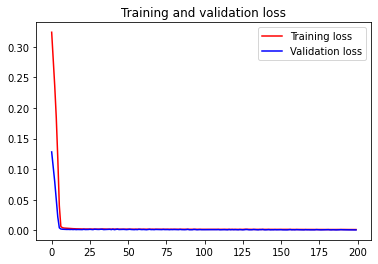

<Figure size 432x288 with 0 Axes>

In [82]:
### Plotting Loss vs Validation loss
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [83]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

((422, 1), (276, 1))

In [84]:
# Model Evaluation
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [85]:
## Evaluation metrices RMSE, MSE and MAE
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  2058.1007638435485
Train data MSE:  4235778.754133399
Train data MAE:  1561.2643406826123
-------------------------------------------------------------------------------------
Test data RMSE:  1447.503478282095
Test data MSE:  2095266.319638764
Test data MAE:  1087.890929250453


In [86]:
## Variance Regression Score
print("Train data explained variance regression score:", 
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", 
      explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9810577193738247
Test data explained variance regression score: 0.9783584401571177


In [87]:
## R square score for regression
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.980098449521938
Test data R2 score: 0.9774844413810387


In [88]:
## Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.002304698096055938
Test data MGD:  0.002148726736937415
----------------------------------------------------------------------
Train data MPD:  94.43239876658174
Test data MPD:  64.51550465455179


In [98]:
# Comparision of original stock close price and predicted close price
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Bitcoin price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (730, 1)
Test predicted data:  (730, 1)


In [90]:
# Predicting next 30 days
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  30


In [91]:
# Plotting last 15 days of dataset and next predicted 30 days
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


In [94]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 30 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Bitcoin price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [99]:
# Plotting entire Closing Stock Price with next 30 days period of prediction
lstmdf=closedf.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'Bitcoin price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing bitcoin price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Bitcoin')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()